# 5. It ain't convoluted

In the previous part we have used an **_MLP_** to recognize hand-written digits.

I hope you found it cool that our understanding of an automatic learning algorithm has brought us from intuition to something that is useful in the real world!

While, we were able to achieve a high accuracy using an **_MLP_** approach, we were treating images as just pixel data.

In reality, images are comprised of many patterns recognizable to us humans, for example, we can see lines (edges), gradients, shapes and so much more.

Can a computer also learn to recognize these visual patterns?

To get started, we need to look back at a little bit of classical **_Computer Vision_**. We, as human beings, have been trying to modify, understand and process images on computers for a really long time (long before machine learning techniques existed in their current form).

Before, we begin our foray into smarter networks, a little bit of initialization.

In [1]:
# Initialization stuff
%matplotlib inline
!gdown https://drive.google.com/uc?id=1LJccUzmjbD_tJ5TF3J3CkkeDNeItElLd
!unzip cgML.zip
import random
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image
import torch
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.autograd import Variable
import PIL.Image as PILImage
from PIL import ImageFilter
import cv2
from scripts.helper import *
plt.style.use('ggplot')
# For reproducibility
random.seed(0)
torch.manual_seed(0)
np.random.seed(0)

Downloading...
From: https://drive.google.com/uc?id=1LJccUzmjbD_tJ5TF3J3CkkeDNeItElLd
To: /content/cgML.zip
35.4MB [00:00, 97.1MB/s]
Archive:  cgML.zip
replace scripts/helper.py? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: scripts/helper.py       
  inflating: scripts/__pycache__/helper.cpython-37.pyc  
  inflating: .ipynb_checkpoints/1 - Facial Landmarks-checkpoint.ipynb  
  inflating: .ipynb_checkpoints/1- Introduction - What is Machine Learning anyway_-checkpoint.ipynb  
  inflating: .ipynb_checkpoints/2 - Automatic Learning-checkpoint.ipynb  
  inflating: .ipynb_checkpoints/3 - A little inspiration from our brain-checkpoint.ipynb  
  inflating: .ipynb_checkpoints/4 - Let's get visual!-checkpoint.ipynb  
  inflating: .ipynb_checkpoints/5 - It ain't convoluted!-checkpoint.ipynb  
  inflating: .ipynb_checkpoints/6 - Putting it all together-checkpoint.ipynb  
  inflating: datasets/MNIST/processed/test.pt  
  inflating: datasets/MNIST/processed/training.pt  
  inflating: datase

### What is an image anyway?

Images can be represented in many forms, but a very popular form of representation is to represent color as comprising of Red, Green and Blue **_(RGB)_** components.

Thus, for every pixel in a colour image, the pixel's color is represented as a red, green and blue component. These are called **_channels_**. 

Thus, an **RGB** color image is a matrix comprising of 3 **_channels_**. 

To understand this concept better, take a look at the picture below:

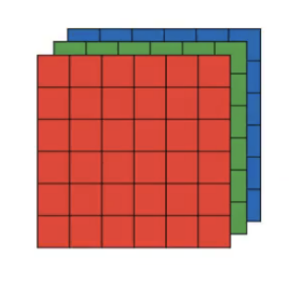

In [2]:
Image("images/rgb-image.png")

In the picture above, we see a depiction of 6x6 pixel color image. As we can see, for each color, we have a separate channel. Thus this image can be represented by a 6x6x3 numpy array.

To solidify our intuition, let's create a few images manually.

In [3]:
# Initialize our image data with zeros
pixels = np.zeros((6, 6, 3), dtype='uint8')
# Set all the pixels in the red channel to 255
pixels[:, :, 0] = 255
img = PILImage.fromarray(pixels, 'RGB')
img

In [4]:
# Initialize our image data with zeros
pixels = np.zeros((6, 6, 3), dtype='uint8')
# Set all the pixels in the green channel to 255
pixels[:, :, 1] = 255
img = PILImage.fromarray(pixels, 'RGB')
img

In [5]:
# Initialize our image data with zeros
pixels = np.zeros((6, 6, 3), dtype='uint8')
# Set all the pixels in the blue channel to 255
pixels[:, :, 2] = 255
img = PILImage.fromarray(pixels, 'RGB')
img

In [6]:
# Set all the pixels in all channels to 127 - this should produce a gray image
pixels = np.zeros((6, 6, 3), dtype='uint8')
# Set all the pixels in the blue channel to 255
pixels[:, :, 0] = 127
pixels[:, :, 1] = 127
pixels[:, :, 2] = 127
img = PILImage.fromarray(pixels, 'RGB')
img

From the above experiments, we now have a clear understanding of what an RGB image is.

A color image is a 3d matrix (representing pixels) where each position of a pixel has 3 **_channels_** representing Red, Green and Blue intensities in the range of 0 (meaning the color in not present at all) to 255 (meaning the color is present in its full intensity).

A grayscale image is a 2d matrix (representing pixels) where each position of a pixel has only 1 channel (representing how white the pixel is - 0 meaning black and 1 meaning white)

This representation gives us 255 x 255 x 255 (16,581,375) distinct colors for **_RGB_** images and 255 shades of gray for **_grayscale_** images.

### What is a convolution?

I am sure you might have seen photo editing software blur or sharpen an image.

Have you ever wondered how they do it?

We're just going to learn how. But first, we need to know what a convolution is.

A convolution is a matrix operation where we slide a matrix (called a *__kernel__*) over an image and multiply the kernel values with the pixel values and then sum them up.

For simplicity, we are going to demonstrate the convolution operation on a single channel grayscale image:

In [9]:
Image("images/convolution.gif")

ValueError: ignored

From the above animation, it should be clear that a kernel must have an **_origin_** or center and therefore it must be of a size (odd number 1 x odd number 2). In practice, we almost always use a square kernel.

In the animation above, the original image was **_padded_** with 1 pixel (assumed to be 0) to preserve the size of the output. If no padding was done, the origin of the 3x3 kernel could only be placed at the position (1, 1) and not (0, 0). Thus, without padding, the size of the output would reduce.

Let's implement a convolution function for gray scale images in python.

In [0]:
def convolve_grayscale(gray_img, kernel):
    '''
        Function to convolve a gray scale image by specified kernel, while preserving
        the output size.
    '''
    assert len(kernel.shape) == 2, \
        "The kernel must always be a 2 dimensional matrix"
    assert kernel.shape[0] % 2 == 1 and kernel.shape[1] % 2 == 1, \
        "The kernel size must always be odd number1 x odd number2"
    assert len(gray_img.shape) == 2, \
        "This function works on only grayscale images"
    
    # Below we calculate the padding needed to preserve the image size
    padding_needed_rows = int(kernel.shape[0]/2)
    padding_needed_cols = int(kernel.shape[1]/2)
    
    # Let's create the padded image
    # Order is top, bottom, left, right
    padded_img = cv2.copyMakeBorder(gray_img,
                                    padding_needed_rows, 
                                    padding_needed_rows, 
                                    padding_needed_cols,
                                    padding_needed_cols,
                                    cv2.BORDER_REFLECT)
    
    # Create the result image
    result_img = np.zeros(gray_img.shape, dtype="float32")
    
    # Kernel size
    kernel_size_rows = kernel.shape[0]
    kernel_size_cols = kernel.shape[1]
    
    # Convolve
    for row in range(0, padded_img.shape[0] - kernel_size_rows + 1):
        for col in range(0, padded_img.shape[1] - kernel_size_cols + 1):
            conv_area = padded_img[row:row+kernel_size_rows, col:col+kernel_size_cols]
            # Elementwise multiply convolution area with the kernel
            kerned_area = conv_area * kernel
            position_value = np.sum(kerned_area)
            
            if position_value > 255:
                position_value = 255
            if position_value < 0:
                position_value = 0
                
            # Set the position in the result
            result_img[row, col] = position_value

    return result_img.astype("uint8")

Let's test our function on the animation data:

In [11]:
data = np.array([[7, 6, 5, 5, 6, 7],
                 [6, 4, 3, 3, 4, 6],
                 [5, 3, 2, 2, 3, 5],
                 [5, 3, 2, 2, 3, 5],
                 [6, 4, 3, 3, 4, 6],
                 [7, 6, 5, 5, 6, 7]], dtype="uint8")
kernel = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])
result = convolve_grayscale(data, kernel)
print("Data:")
print(data)
print("Kernel:")
print(kernel)
print("Result:")
print(result)

Data:
[[7 6 5 5 6 7]
 [6 4 3 3 4 6]
 [5 3 2 2 3 5]
 [5 3 2 2 3 5]
 [6 4 3 3 4 6]
 [7 6 5 5 6 7]]
Kernel:
[[ 0 -1  0]
 [-1  5 -1]
 [ 0 -1  0]]
Result:
[[9 8 6 6 8 9]
 [8 2 1 1 2 8]
 [6 1 0 0 1 6]
 [6 1 0 0 1 6]
 [8 2 1 1 2 8]
 [9 8 6 6 8 9]]


Let's load up and look at a grayscale image:

Shape of image is (303, 497)


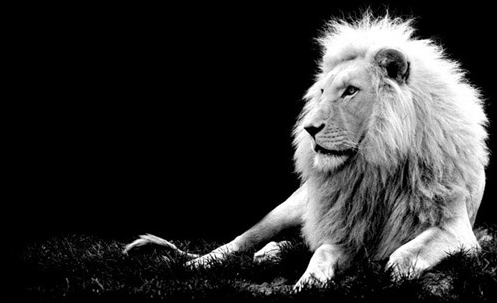

In [12]:
lion = PILImage.open("images/lion.png").convert('L')
lion_pixels = np.array(lion)
print("Shape of image is {}".format(lion_pixels.shape))
lion

From the shape, we can see that it is a grayscale image.

Let's try to apply a sharpening kernel to this image!

Kernel:
[[ 0 -1  0]
 [-1  5 -1]
 [ 0 -1  0]]


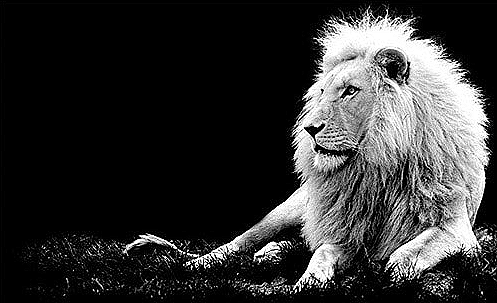

In [13]:
sharpen_kernel = np.array([[0, -1, 0],
                           [-1, 5, -1],
                           [0, -1, 0]])
print("Kernel:")
print(sharpen_kernel)
lion_pixels_sharpened = convolve_grayscale(lion_pixels, sharpen_kernel)
sharpened_lion = PILImage.fromarray(lion_pixels_sharpened)
sharpened_lion

Let's detect edges:

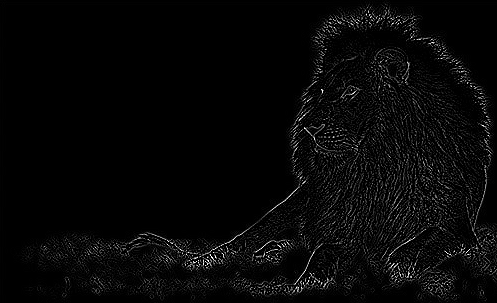

In [14]:
edge_kernel = np.array([[0, 1, 0],
                        [1, -4, 1],
                        [0, 1, 0]])

lion_pixels_edged = convolve_grayscale(lion_pixels, edge_kernel)
edge_lion = PILImage.fromarray(lion_pixels_edged)
edge_lion

So far, we've dealt with only single channel image convolutions. But we can also convolve volumes.

It the case of RGB images, our kernels are 3D, but the convolution is still a 2d convolution as the sliding window moves only in the x and y directions.

The diagram below shows the result of 2d convolving volumes:

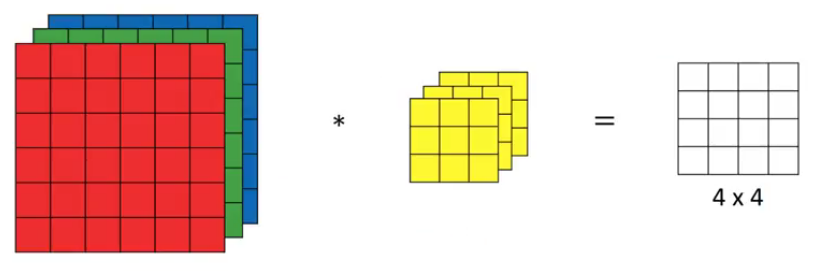

In [15]:
Image("images/convolve-3d.png")

In the diagram, we have 6x6 RGB image of size (6, 6, 3). The image is convolved with (3, 3, 3) kernel to produce a (4, 4) output.

The convolution function we implemented earlier did some automatic **_padding_** of the image to preserve the size of the image.

In the example above, no padding was added. Thus the convolution reduced the size of the output. 

Furthermore, in all our examples, our convolution kernel slides from left to right and top to down one position at a time. To enable the kernel to slide more than one position at a time, we introduce the concept of **_stride_**.

To generalize the concept, convolutions accept explicit **_padding_** and **_stride_** parameters.

Let's implement convolution over volumes:

In [0]:
def convolve_2d(input_volume, kernel, padding=0, stride=1, scale=1):
    # For grayscale images
    if len(input_volume.shape) == 2:
        # Expand the volume with another dimension at the end to make it a 3d volume
        input_volume = np.expand_dims(input_volume, axis=2)
    if len(kernel.shape) == 2:
        # Expand the volume with another dimension at the end to make it a 3d volume
        kernel = np.expand_dims(kernel, axis=2)
        
    # We can only proceed with 3d volumes, grayscale case is already converted to 3d
    # Any other shape is an error
    assert len(input_volume.shape) == 3 and len(kernel.shape) == 3, \
        "Could not interpret input_volume or kernel as valid sized entities"
    
    # Kernels can only be odd number1 x odd number 2 in x, y dimensions
    assert kernel.shape[0] % 2 == 1 and kernel.shape[1] % 2 == 1, \
        "The kernel size must always be odd number1 x odd number2"
    
    # Kernel depth in z dimension must be same as the input volume depth in the z dimension
    assert kernel.shape[2] == input_volume.shape[2], \
        "The kernel must have the same depth as the input volume"
    
    # Let's create the padded image
    # Order is top, bottom, left, right
    padded_image = np.zeros((input_volume.shape[0] + 2 * padding,
                             input_volume.shape[1] + 2 * padding,
                             input_volume.shape[2]), dtype="float32")
    for channel in range(input_volume.shape[2]):
        padded_channel = cv2.copyMakeBorder(input_volume[:,:,channel],
                                            padding, 
                                            padding, 
                                            padding,
                                            padding,
                                            cv2.BORDER_REFLECT)
        padded_image[:,:,channel] = padded_channel / scale
        
    # Kernel size
    kernel_size_rows = kernel.shape[0]
    kernel_size_cols = kernel.shape[1]
    
    # Convolve
    final_list = []
    for row in range(0, padded_image.shape[0] - kernel_size_rows + 1, stride):
        row_list = []
        for col in range(0, padded_image.shape[1] - kernel_size_cols + 1, stride):
            conv_volume = padded_image[row:row+kernel_size_rows, col:col+kernel_size_cols, :]
            # Elementwise multiply convolution area with the kernel
            kerned_volume = conv_volume * kernel
            position_value = round(np.sum(kerned_volume) * scale)
            
            if position_value > 255:
                position_value = 255
            if position_value < 0:
                position_value = 0
                
            # Set the position in the result
            row_list.append(position_value)
        final_list.append(row_list)
        
    return np.array(final_list).astype("uint8")

Let's use our function on a colour image:

Shape of image is (400, 600, 3)


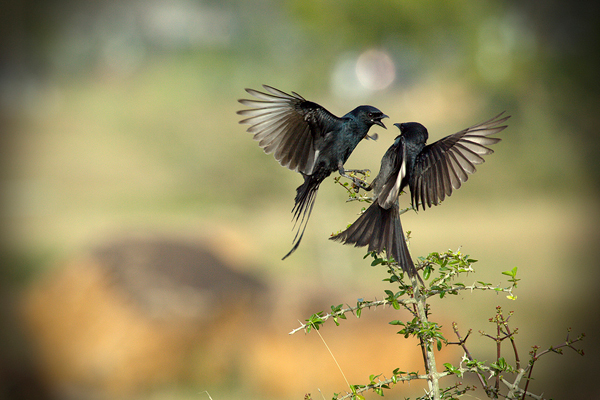

In [17]:
birds = PILImage.open("images/birds.jpg")
birds_pixels = np.array(birds)
print("Shape of image is {}".format(birds_pixels.shape))
birds

Convolved image shape is (400, 600)


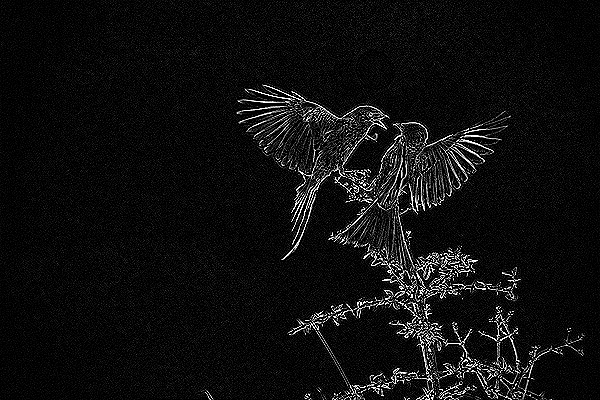

In [18]:
# You may experiment with the kernel values to see the patterns that can be extracted
# using this approach
kernel = np.zeros((3, 3, 3))

red_kernel = np.array([[0, 1, 0],
                       [1, -4, 1],
                       [0, 1, 0]])

blue_kernel = np.array([[0, 1, 0],
                       [1, -4, 1],
                       [0, 1, 0]])
green_kernel = np.array([[0, 1, 0],
                        [1, -4, 1],
                        [0, 1, 0]])

kernel[:,:,0] = red_kernel
kernel[:,:,1] = blue_kernel
kernel[:,:,2] = green_kernel

# You can try to experiment with changing padding and stride parameters
# Incresing stride will downsample the image
convolved_pixels = convolve_2d(birds_pixels, kernel, padding=1, stride=1)
print("Convolved image shape is {}".format(convolved_pixels.shape))
convolved = PILImage.fromarray(convolved_pixels)
convolved

### How are convolutions useful?

So far, we have been specifying kernels by hand. We saw that we can do edge detection by convolving an image with the appropriate kernel.

A different kernel may detect only vertical edges, or only horizontal edges etc.

Thus, a kernel is able to extract useful patterns from images.

What if we could automatically **_learn_** kernels just as we have been learning weights in the previous section?

This is the main idea behind **_convolutional neural networks_**.

To build up our intuition, let's start with a single convolution unit and try to learn a blurring kernel.

From the diagram above, it should be clear that when we convolve a 3d volume with a 3d kernel, we end up with a 2d output.

Since we want the result of our convolution to still contain 3 channels, we will need to convolve not with 1 3d kernel, but with 3 3d kernels each producing a 2d output.

Thus, in total, we will be learning 3 x 3 x 3 x 3 weights for a 3d 3x3 kernel that produces an output with 3 channels.

Let's work with an RGB image this time. First let's load the image and display it

Original image shape (667, 1000, 3)
Channels first image shape (3, 667, 1000)
Batchified training data shape (1, 3, 667, 1000)


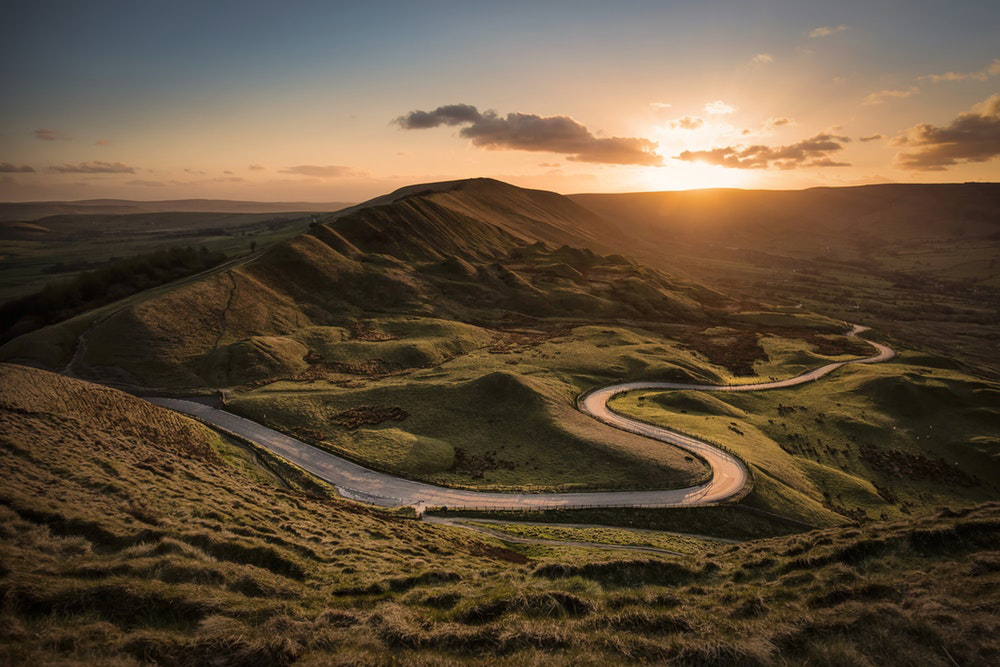

In [19]:
train_img = PILImage.open("images/landscape.jpeg")

# This is for testing later
landscape_pixels = np.array(train_img)

train_X = np.array(train_img)
print("Original image shape {}".format(train_X.shape))

# Let's bring channels in front
train_X = np.transpose(train_X, [2,0,1])
print("Channels first image shape {}".format(train_X.shape))

# Add another dimension for batch
train_X = np.expand_dims(train_X, axis=0)
print("Batchified training data shape {}".format(train_X.shape))

# Make it a tensor
X_train = Variable(torch.Tensor(train_X / 255))

train_img

In [20]:
# This will flatten the input
class Flatten(torch.nn.Module):
    def forward(self, x):
        x = x.view(x.size()[0], -1)
        return x

# Model with a single convolution with 3 input channels, 3 output channels, padding of 1
# and a 3x3 kernel
# This yields an output the same size as the input!
model = torch.nn.Sequential(
    # Output shape of convolution is [1, 3, 667, 1000]
    torch.nn.Conv2d(3, 3, (3,3), stride=1, padding=1, bias=False),
    # We want a flat output so that we can use MSE to train the network
    # Output shape will be [1, 2001000]
    Flatten())

output = model(X_train)
print("Result from model is of shape {}".format(output.shape))
print("Model weights are of shape {}".format(model.state_dict()['0.weight'].shape))

Result from model is of shape torch.Size([1, 2001000])
Model weights are of shape torch.Size([3, 3, 3, 3])


Let's look at the transformation we want the model to learn. Let's blur our input image and use that as the ground truth:

Original output image shape (667, 1000, 3)
Channels first output image shape (3, 667, 1000)
Flattened training data y shape (2001000,)
Final training data y shape (1, 2001000)


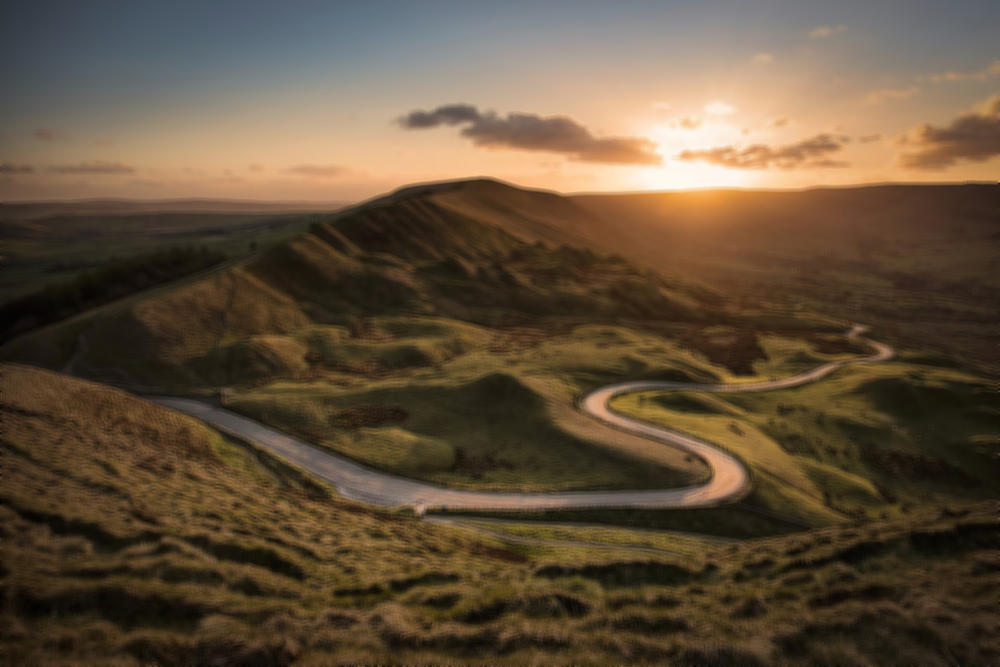

In [21]:
train_img_output = train_img.filter(ImageFilter.BLUR)

train_y = np.array(train_img_output)
print("Original output image shape {}".format(train_y.shape))

# Let's bring channels in front
train_y = np.transpose(train_y, [2,0,1])
print("Channels first output image shape {}".format(train_y.shape))

# Let's flatten it
train_y = train_y.flatten()
print("Flattened training data y shape {}".format(train_y.shape))

# Let's add 1 dimension
train_y = np.expand_dims(train_y, axis=0)
print("Final training data y shape {}".format(train_y.shape))

# Make it a tensor
y_train = Variable(torch.Tensor(train_y / 255))

train_img_output

In [22]:
cost = torch.nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

# trainning
ave_loss = 0

# Training loop
for epoch in range(5000): 
    # Forward pass: Compute predicted y by passing  
    # x to the model 
    y_hat = model(X_train)
  
    # Compute and print loss 
    loss = cost(y_hat, y_train)
    
    # Use an exponentially weighted average for running loss value
    ave_loss = ave_loss * 0.9 + loss.data * 0.1
  
    # Zero gradients, perform a backward pass,  
    # and update the weights. 
    optimizer.zero_grad() 
    loss.backward() 
    optimizer.step() 
    if (epoch) % 100 == 0:
            print('==>>> epoch: {}, train loss: {:.6f}'.format(
                epoch, ave_loss))

==>>> epoch: 0, train loss: 0.024310
==>>> epoch: 100, train loss: 0.002826
==>>> epoch: 200, train loss: 0.001794
==>>> epoch: 300, train loss: 0.001318
==>>> epoch: 400, train loss: 0.001088
==>>> epoch: 500, train loss: 0.000968
==>>> epoch: 600, train loss: 0.000899
==>>> epoch: 700, train loss: 0.000854
==>>> epoch: 800, train loss: 0.000822
==>>> epoch: 900, train loss: 0.000797
==>>> epoch: 1000, train loss: 0.000776
==>>> epoch: 1100, train loss: 0.000758
==>>> epoch: 1200, train loss: 0.000743
==>>> epoch: 1300, train loss: 0.000729
==>>> epoch: 1400, train loss: 0.000717
==>>> epoch: 1500, train loss: 0.000706
==>>> epoch: 1600, train loss: 0.000695
==>>> epoch: 1700, train loss: 0.000686
==>>> epoch: 1800, train loss: 0.000677
==>>> epoch: 1900, train loss: 0.000668
==>>> epoch: 2000, train loss: 0.000661
==>>> epoch: 2100, train loss: 0.000653
==>>> epoch: 2200, train loss: 0.000646
==>>> epoch: 2300, train loss: 0.000640
==>>> epoch: 2400, train loss: 0.000634
==>>> epoch:

Let's see what the model is doing with the input image:

Raw output shape: (1, 2001000)
Raw output reshaped: (1, 3, 667, 1000)
Raw output pixels: (667, 1000, 3)


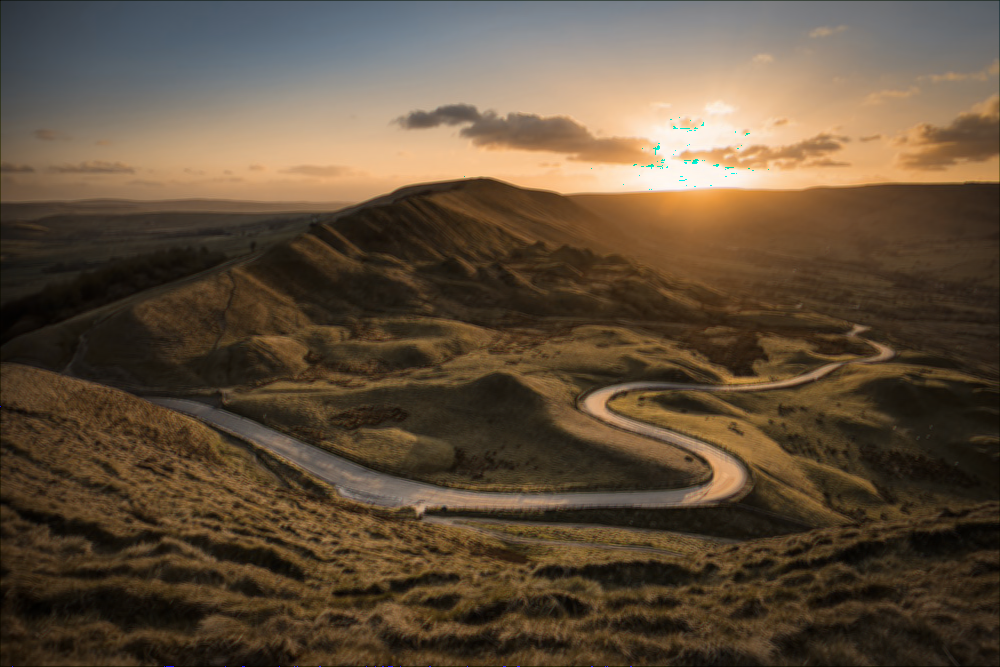

In [23]:
output = model(X_train).detach().numpy()
print("Raw output shape: {}".format(output.shape))
output = output.reshape((1, 3, 667, 1000))
print("Raw output reshaped: {}".format(output.shape))
output_pixels = np.transpose(output, (0,2,3,1))[0] * 255
print("Raw output pixels: {}".format(output_pixels.shape))
img = PILImage.fromarray(output_pixels.astype("uint8"), 'RGB')
img

Check that out! Our single convolutional unit learned weights to blur the image! To solidify our understanding, let's take a look at the weights our convolutional unit learned:

Weights:
tensor([[[[ 0.1670,  0.2610,  0.0364],
          [-0.0124,  0.0068,  0.1175],
          [ 0.1442,  0.2127,  0.0235]],

         [[ 0.1253,  0.0047,  0.0576],
          [-0.1311, -0.1198, -0.0883],
          [ 0.0737,  0.0609,  0.0827]],

         [[-0.1347, -0.1013,  0.0780],
          [ 0.1512, -0.0881,  0.0767],
          [-0.0336, -0.0551,  0.0849]]],


        [[[-0.0075, -0.0419,  0.0421],
          [-0.0073,  0.1883, -0.0572],
          [ 0.0437,  0.0145,  0.0209]],

         [[ 0.0290,  0.2144,  0.1441],
          [ 0.1446,  0.0175, -0.0482],
          [ 0.1374, -0.0558,  0.0364]],

         [[-0.0741,  0.0538,  0.0497],
          [-0.1363, -0.1006,  0.0680],
          [ 0.1697,  0.0759,  0.0762]]],


        [[[ 0.1004, -0.1387,  0.0512],
          [-0.1779, -0.1365, -0.0530],
          [ 0.0711,  0.1207,  0.0032]],

         [[ 0.0112,  0.0562, -0.0360],
          [-0.0252,  0.0328,  0.1536],
          [ 0.1740, -0.1030,  0.0450]],

         [[ 0.0862,  0.1617,  0.203

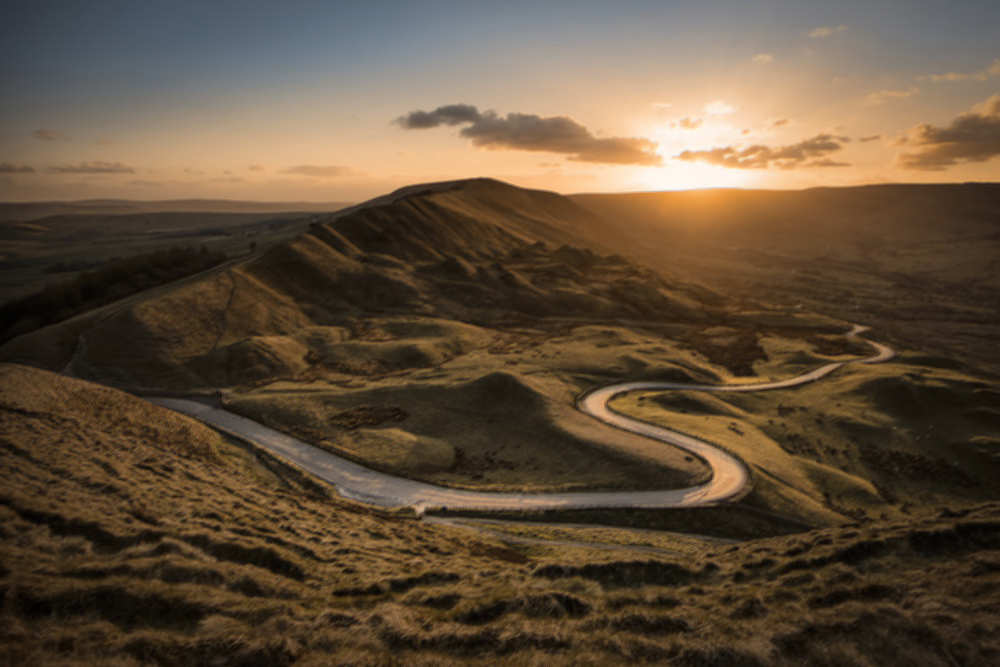

In [24]:
weights = model.state_dict()['0.weight']
print("Weights:")
print(weights)

# Let's try to apply these weights manually
filter1 = weights[0].detach().numpy().T
filter2 = weights[1].detach().numpy().T
filter3 = weights[2].detach().numpy().T

filter1_output = convolve_2d(landscape_pixels, filter1, padding=1, stride=1, scale=255) 
filter2_output = convolve_2d(landscape_pixels, filter2, padding=1, stride=1, scale=255)
filter3_output = convolve_2d(landscape_pixels, filter3, padding=1, stride=1, scale=255)

image_from_weights_pixels = np.transpose(np.array([filter1_output, filter2_output, filter3_output]), (1, 2, 0))
image_from_weights = PILImage.fromarray(image_from_weights_pixels)
image_from_weights

See? No magic here. All we did was to use **_stochastic gradient descent_** to learn the kernel weights for 3 separate kernels (also called **_filters_**). Then we used the 3 kernels to apply convolution on the image. The output from each of the 3 kernels was a 2d matrix. We then stacked these 3 2d matrices to create our RGB image.

Before we move on, let's try our model on another image:

Original test image shape (710, 1920, 3)
Channels first test image shape (3, 710, 1920)
Batchified training data shape (1, 3, 710, 1920)


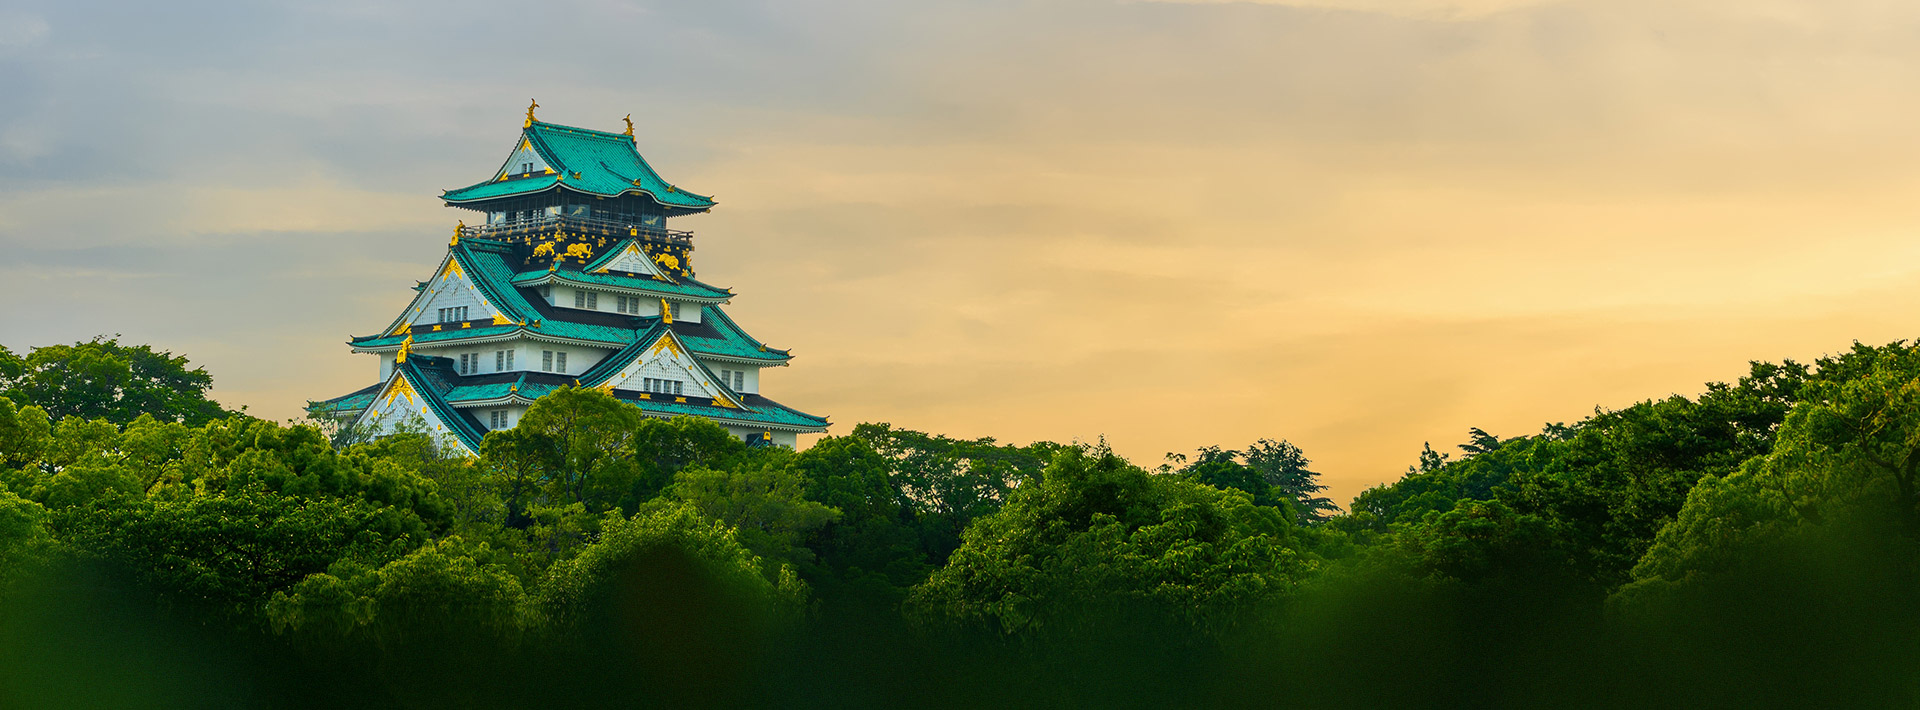

In [25]:
test_img = PILImage.open("images/landscape2.jpg")

test_X = np.array(test_img)
print("Original test image shape {}".format(test_X.shape))

# Let's bring channels in front
test_X = np.transpose(test_X, [2,0,1])
print("Channels first test image shape {}".format(test_X.shape))

# Add another dimension for batch
test_X = np.expand_dims(test_X, axis=0)
print("Batchified training data shape {}".format(test_X.shape))

# Make it a tensor
X_test = Variable(torch.Tensor(test_X / 255))

test_img

Raw output shape: (1, 4089600)
Raw output reshaped: (1, 3, 710, 1920)
Raw output pixels: (710, 1920, 3)


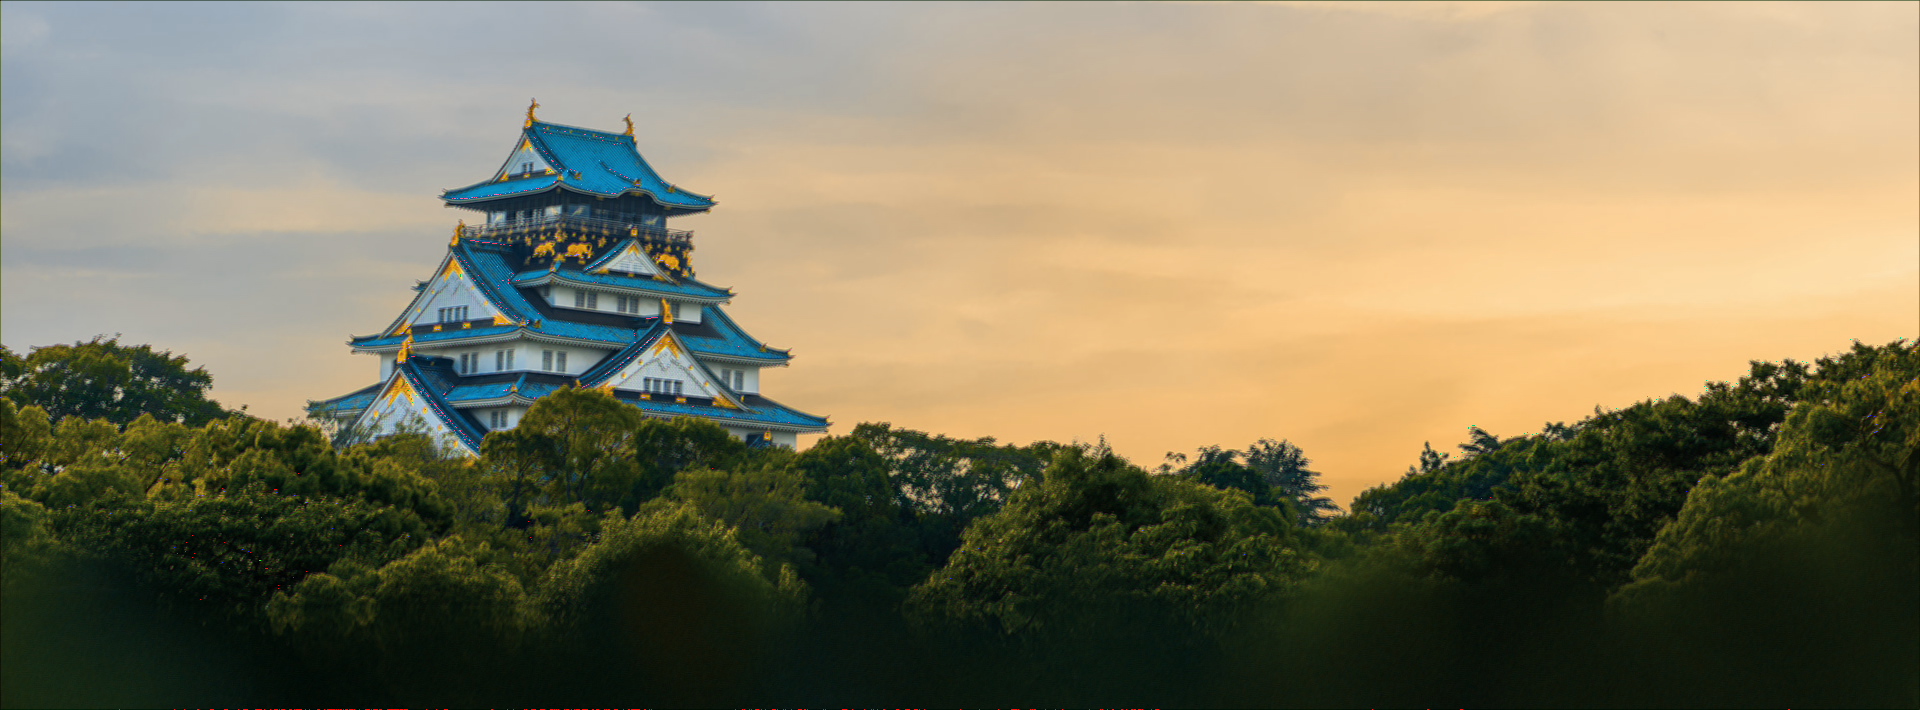

In [26]:
output = model(X_test).detach().numpy()
print("Raw output shape: {}".format(output.shape))
output = output.reshape((1, 3, 710, 1920))
print("Raw output reshaped: {}".format(output.shape))
output_pixels = np.transpose(output, (0,2,3,1))[0] * 255
print("Raw output pixels: {}".format(output_pixels.shape))
img = PILImage.fromarray(output_pixels.astype("uint8"), 'RGB')
img

We trained the model on just one image. When we apply the model to a second image, we can see it did affect the image and blur it a just a little bit (especially look at the tree regions - green tree regions were present in our training image so the model does better here).

This phenomenon when the model does well on training data but not as well on test data is called **_over-fitting_**. We can reduce **_over-fitting_** by training the model on a larger dataset. **_Over-fitting_** can also be overcome by introducing **_regularization techniques_** such as **_drop-out_**. It is left as an exercise to the reader to read more about regularization.

### What's so great about convolutional networks?

In the last section, when we treated pixels as data, we ended up with a network that could accept input of only a fixed size. Furthermore, our previous model had more than half a million weights that it needed to learn. As our pictures increased in resolution, treating pixels as data would mean learning even more weights!

Convolutional neural networks, on the other hand only learn the weights of the convolutional kernel. In this case, we learnt only 3 x 3 x 3 x 3 = 81 weights to achieve this blurring effect.

Furthermore, since we are applying this kernel to the image, the image can be of any size. In the examples above, we used two different images of different sizes.

One further benefit of of **_CNNs_** is that there is translational invariance. What that means is that if a kernel learns to amplify a certain pattern, it doesn't matter where in the image that pattern occurs as the kernel slides over the entire image.

### We trained a single convolutional unit, what does a deep CNN look like?

Typically CNN architectures start with a 3d volume. Since they typically operate on images, this would be an (x, y, 3) volume. Architectures are created by stacking up convolutional units and also using **_pooling_** to reduce volume in the x and y dimensions. Later layers in the network become smaller and smaller in the x and y dimensions but grow bigger and bigger in the z dimension.

A picture is show below:

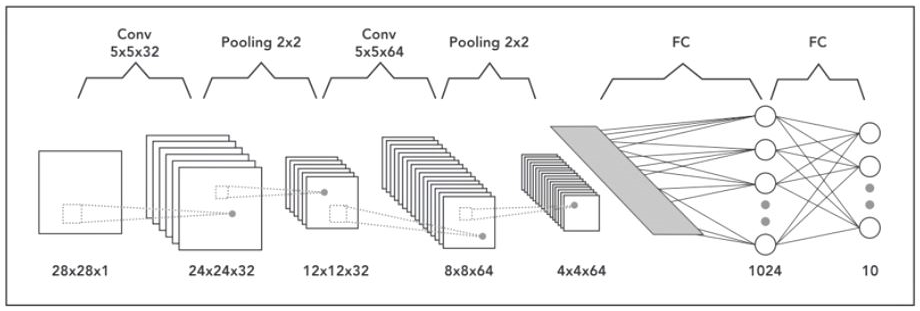

In [27]:
Image("images/cnn.png")

## What just happened?

1. We started this section by understanding the concept of a convolution.
2. We then tried some convolutions with hand-designed kernels.
3. We trained a single convolutional unit to perform a blur operation on a single image dataset.
4. We inspected the learned weights and used the convolution function we wrote ourselves to verify that this is not magic :-)
5. We observed that the unit learned to perform the operation well on the image but faltered on another image.
6. Through this phenomenon, we understood the concept of **_over-fitting_** and briefly introduced **_regularization_**.
7. We observed that, unlike the **_fully-connected_** networks or **_MLPs_** we used in the past, convolutional networks have far less parameters.
8. We then looked at how convolutional units can be stacked together to form a deep convolutional network.
9. We briefly mentioned **_pooling_** as a technique to reduce volume in the x and y dimensions.

## What's next?

In the last and final section of this workshop, we will understand pooling. Then, we will go back to the MNIST dataset and try to train a convolutional neural network on the same dataset.